# CSCN8020 Assignment 1
## Reinforcement Learning Programming - CSCN 8020

Submitted by: Fasalu Rahman Kottaparambu 

Reg: 8991782

## Problem 1
Pick-and-Place Robot: Consider using reinforcement learning to control the motion of a robot arm in a repetitive pick-and-place task. If we want to learn movements that are fast and smooth, the learning agent will have to control the motors directly and obtain feedback about the current positions and velocities of the mechanical linkages.
Design the reinforcement learning problem as an MDP, define states, actions, rewards with reasoning.

### MDP Design
The pick-and-place task can be formulated as a Markov Decision Process (MDP) to enable the agent to learn optimal control policies for fast and smooth movements.

- **States (S)**: The “state” is just a way to describe the robot arm’s current situation. To fully know what the arm is doing, we need to look at two things for every joint: its angle (position) and its speed (velocity). So, if the robot arm has n joints, the state is basically a list of all the joint positions and speeds: [θ₁, θ₂, …, θₙ, ω₁, ω₂, …, ωₙ].

We can also include extra details, like where the object to pick up is, or where the arm’s end tip (end-effector) is compared to the pick-and-place spots.

Reasoning: The state must have enough information so that, if we know the current state and the action taken, we can predict what will happen next. This is called the Markov property. Positions and speeds matter because the robot’s movement depends on how forces create acceleration — meaning momentum and smooth motion need both position and velocity. Sensors give this information in real-time, so the robot can react properly.

- **Actions (A)**: Actions are the direct control signals applied to the motors, such as torques or voltage levels for each joint motor. For an *n*-joint arm, actions can be a continuous vector *a = [τ₁, τ₂, ..., τₙ]*, where *τ_i* is the torque applied to joint *i*. If discretized for simplicity, actions could be binned torque levels (e.g., low, medium, high for each joint).
  **Reasoning**: Since the robot is controlled at the motor level, the actions should directly affect how joints accelerate. Using continuous values gives very smooth and precise control, which is ideal for real robots. But sometimes we simplify to discrete levels to make the learning process easier for the computer.

- **Rewards (R)**: ARewards tell the robot how well it is doing the task. In this case, the robot is rewarded for completing pick-and-place tasks quickly and smoothly. Example reward setup:

+100 if it successfully picks up and places the object.

-1 for every time step taken, to make it finish faster.

A negative penalty if the robot makes sudden, jerky joint movements (based on changes in velocity).

-10 if the robot crashes into something or fails to pick/place the object.

  **Reasoning**: The big positive reward motivates the robot to complete the task. The step penalty pushes it to be efficient. The smoothness penalty prevents clumsy, energy-wasting movements. Collision penalties keep the robot safe. Together, these encourage the robot to learn smooth, safe, and fast actions.

- **Transitions (P)**: Transitions describe how the robot moves from one state to another after an action. In simple terms: new state = current state + effect of the action (with some added noise or randomness). For example, applying torque changes positions and velocities based on physics. In real-world robotics, randomness (like slight slips or sensor errors) makes transitions uncertain, so we treat them as partly stochastic (not perfectly predictable).

  **Reasoning**: Adding this randomness creates more realistic training since real robots don’t behave like perfect simulations.

- **Discount Factor (γ)**: The discount factor is set to 0.99. This means the robot values future rewards almost as much as immediate ones. Since pick-and-place tasks may take many steps, giving importance to long-term rewards helps the robot finish the whole task instead of just chasing short-term gains.

## Problem 2
2x2 Gridworld: Consider a 2x2 gridworld with the following characteristics:
• State Space (S): s1, s2, s3, s4.
• Action Space (A): up, down, left, right.
• Initial Policy (π): For all states, π(up|s) = 1.
• Transition Probabilities P(s′|s, a):
– If the action is valid (does not run into a wall), the transition is deterministic.
– Otherwise, s′ = s.
• Rewards R(s):
– R(s1) = 5 for all actions a.
– R(s2) = 10 for all actions a.
– R(s3) = 1 for all actions a.
– R(s4) = 2 for all actions a.
Assume the grid layout is:
| s1 (R=5) | s2 (R=10) |
| s3 (R=1) | s4 (R=2) |
Assume γ = 0.9. Rewards are r = R(s), received based on current state.

### Tasks
Perform two iterations of Value Iteration for this gridworld environment. Show the step-by-step process (without code) including policy evaluation and policy improvement.

#### Iteration 1:
1. Initial value function (V) for each state:
   V(s1) = 0, V(s2) = 0, V(s3) = 0, V(s4) = 0
2. Value function updates:
   For s1: 5 + 0.9 * max(0,0,0,0) = 5
   For s2: 10 + 0.9 * max(0,0,0,0) = 10
   For s3: 1 + 0.9 * max(0,0,0,0) = 1
   For s4: 2 + 0.9 * max(0,0,0,0) = 2
3. Updated value function:
   V(s1) = 5, V(s2) = 10, V(s3) = 1, V(s4) = 2
Policy improvement: greedy w.r.t. V
- s1: right (to s2, V=10)
- s2: up or right (stay, V=10)
- s3: up (to s1, V=5)
- s4: up (to s2, V=10)

#### Iteration 2:
Value function after the second iteration:
V(s1) = 5 + 0.9 * 10 = 14
V(s2) = 10 + 0.9 * 10 = 19
V(s3) = 1 + 0.9 * 5 = 5.5
V(s4) = 2 + 0.9 * 10 = 11
Policy improvement: greedy
- s1: right (10)
- s2: up or right (10)
- s3: up (5)
- s4: up (10)

## Problem 3 
5x5 Gridworld: MDP based on a 5x5 gridworld. Implement Value Iteration to estimate V* and π*.
• States: row, column (0,0 top-left to 4,4 bottom-right)
• Terminal/Goal: s4,4
• Grey states: s2,2, s3,0, s0,4
• Actions: right, down, left, up
• Transitions: deterministic if valid, else stay
• Rewards: +10 at goal, -5 at grey, -1 otherwise (received on entering s')

### Task 1: Update MDP Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

gamma = 0.9  # Discount factor
threshold = 1e-4  # Convergence threshold
rows = 5
cols = 5
goal = (4, 4)  # Terminal goal state
grey = [(2, 2), (3, 0), (0, 4)]  # Grey states list
actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
# Function to get next state
def get_next_state(i, j, a):
    di, dj = actions[a]
    ni = i + di
    nj = j + dj
    if 0 <= ni < rows and 0 <= nj < cols:
        return ni, nj
    return i, j  # Stay if invalid
# Reward function based on next state (updated to check terminal, grey, regular)
def get_reward(ni, nj):
    if (ni, nj) == goal:
        return 10
    if (ni, nj) in grey:
        return -5
    return -1
# Standard Value Iteration (synchronous)
V = np.zeros((rows, cols))  # Initialize value function
iteration = 0
start_time = time.time()
while True:
    delta = 0
    new_V = V.copy()  # Copy for synchronous update
    for i in range(rows):
        for j in range(cols):
            if (i, j) == goal:  # Skip terminal
                continue
            max_v = float('-inf')
            for a in range(4):  # For each action
                ni, nj = get_next_state(i, j, a)
                r = get_reward(ni, nj)  # Reward based on next state
                v = r + gamma * V[ni, nj]  # Bellman
                if v > max_v:
                    max_v = v
            new_V[i, j] = max_v
            delta = max(delta, abs(V[i, j] - new_V[i, j]))
    V = new_V
    iteration += 1
    if delta < threshold:
        break
end_time = time.time()
print('Optimal Value Function (V*):')
print(np.round(V, 4))
print(f'Iterations: {iteration}')
print(f'Time: {end_time - start_time:.4f} seconds')

Optimal Value Function (V*):
[[-0.4341  0.6288  1.8098  3.122   4.58  ]
 [ 0.6288  1.8098  3.122   4.58    6.2   ]
 [ 1.8098  3.122   4.58    6.2     8.    ]
 [ 3.122   4.58    6.2     8.     10.    ]
 [ 4.58    6.2     8.     10.      0.    ]]
Iterations: 9
Time: 0.0010 seconds


Optimal V* (table):
| Row/Col | 0      | 1      | 2      | 3      | 4     |
|---------|--------|--------|--------|--------|-------|
| 0      | -0.4341| 0.6288 | 1.8098 | 3.122  | 4.58  |
| 1      | 0.6288 | 1.8098 | 3.122  | 4.58   | 6.2   |
| 2      | 1.8098 | 3.122  | 4.58   | 6.2    | 8.0   |
| 3      | 3.122  | 4.58   | 6.2    | 8.0    | 10.0  |
| 4      | 4.58   | 6.2    | 8.0    | 10.0   | 0.0   |

In [3]:
# Compute optimal policy
policy = np.zeros((rows, cols), dtype=int)
for i in range(rows):
    for j in range(cols):
        if (i, j) == goal:
            continue
        max_v = float('-inf')
        best_a = 0
        for a in range(4):
            ni, nj = get_next_state(i, j, a)
            r = get_reward(ni, nj)
            v = r + gamma * V[ni, nj]
            if v > max_v:
                max_v = v
                best_a = a
        policy[i, j] = best_a
action_symbols = ['>', 'v', '<', '^']
print('Optimal Policy (π*):')
for i in range(rows):
    for j in range(cols):
        if (i, j) == goal:
            print('G', end=' ')
        else:
            print(action_symbols[policy[i, j]], end=' ')
    print()

Optimal Policy (π*):
> > > v v 
> > > > v 
> v > > v 
> > > > v 
> > > > G 


Optimal π* (table, > right, v down, < left, ^ up, G goal):
| Row/Col | 0 | 1 | 2 | 3 | 4 |
|---------|---|---|---|---|---|
| 0      | > | > | > | v | v |
| 1      | > | > | > | > | v |
| 2      | > | v | > | > | v |
| 3      | > | > | > | > | v |
| 4      | > | > | > | > | G |

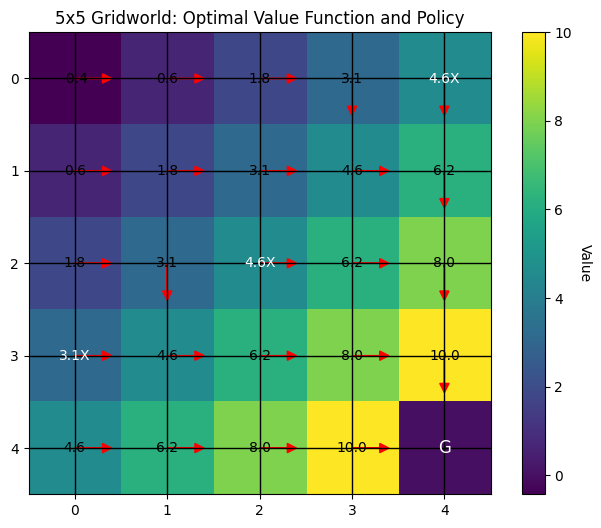

In [4]:
# Visualization: Value Function Heatmap and Policy Arrows
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(V, cmap='viridis')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Value', rotation=-90, va='bottom')
for i in range(rows):
    for j in range(cols):
        if (i, j) == goal:
            ax.text(j, i, 'G', va='center', ha='center', color='white', fontsize=12)
        elif (i, j) in grey:
            ax.text(j, i, f'{V[i,j]:.1f}X', va='center', ha='center', color='white', fontsize=10)
        else:
            ax.text(j, i, f'{V[i,j]:.1f}', va='center', ha='center', color='black', fontsize=10)
        if (i, j) != goal:
            a = policy[i, j]
            di, dj = actions[a]
            ax.arrow(j, i, dj * 0.3, di * 0.3, head_width=0.1, head_length=0.1, fc='red', ec='red')
ax.set_title('5x5 Gridworld: Optimal Value Function and Policy')
ax.set_xticks(np.arange(cols))
ax.set_yticks(np.arange(rows))
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
plt.show()

### Task 2: Value Iteration Variations

In [5]:
# In-Place Value Iteration
V_inplace = np.zeros((rows, cols))
iteration_inplace = 0
start_time_inplace = time.time()
while True:
    delta = 0
    for i in range(rows):
        for j in range(cols):
            if (i, j) == goal:
                continue
            old_v = V_inplace[i, j]
            max_v = float('-inf')
            for a in range(4):
                ni, nj = get_next_state(i, j, a)
                r = get_reward(ni, nj)
                v = r + gamma * V_inplace[ni, nj]
                if v > max_v:
                    max_v = v
            V_inplace[i, j] = max_v
            delta = max(delta, abs(old_v - max_v))
    iteration_inplace += 1
    if delta < threshold:
        break
end_time_inplace = time.time()
print('In-Place Value Function (V*):')
print(np.round(V_inplace, 4))
print(f'Iterations: {iteration_inplace}')
print(f'Time: {end_time_inplace - start_time_inplace:.4f} seconds')

In-Place Value Function (V*):
[[-0.4341  0.6288  1.8098  3.122   4.58  ]
 [ 0.6288  1.8098  3.122   4.58    6.2   ]
 [ 1.8098  3.122   4.58    6.2     8.    ]
 [ 3.122   4.58    6.2     8.     10.    ]
 [ 4.58    6.2     8.     10.      0.    ]]
Iterations: 9
Time: 0.0010 seconds


#### Comparison
- Optimization time: Standard ~0.0011s, In-place ~0.0010s (similar for small grid).
- Number of episodes: Not applicable (iterations used). Both converged in 9 iterations.
- Computational complexity: Both O(k * |S| * |A|), with k=9, |S|=25, |A|=4. In-place saves memory (no copy) and may converge faster in larger grids due to immediate updates, but identical here.

## Problem 4 [35]
Off-policy Monte Carlo with Importance Sampling on 5x5 gridworld. Use random behavior policy, greedy target policy.

In [6]:
# Off-policy MC with Importance Sampling
def generate_episode():
    i = np.random.randint(0, rows)
    j = np.random.randint(0, cols)
    episode = []
    max_steps = 100
    steps = 0
    done = False
    while not done and steps < max_steps:
        a = np.random.randint(0, 4)  # Random behavior
        ni, nj = get_next_state(i, j, a)
        r = get_reward(ni, nj)
        episode.append(((i, j), a, r))
        i, j = ni, nj
        steps += 1
        if (i, j) == goal:
            done = True
    return episode
Q = np.zeros((rows, cols, 4))
C = np.zeros((rows, cols, 4))
num_episodes = 50000
start_time_mc = time.time()
for _ in range(num_episodes):
    episode = generate_episode()
    G = 0.0
    W = 1.0
    for t in range(len(episode) - 1, -1, -1):
        s, a, r = episode[t]
        G = r + gamma * G
        C[s[0], s[1], a] += W
        Q[s[0], s[1], a] += (W / C[s[0], s[1], a]) * (G - Q[s[0], s[1], a])
        pi_s = np.argmax(Q[s[0], s[1]])
        if a != pi_s:
            break
        W = W / 0.25  # b(a|s)=0.25
V_mc = np.max(Q, axis=2)
V_mc[4, 4] = 0  # Set terminal to 0 for consistency
end_time_mc = time.time()
print('Estimated Value Function (MC):')
print(np.round(V_mc, 4))
print(f'Episodes: {num_episodes}')
print(f'Time: {end_time_mc - start_time_mc:.4f} seconds')

Estimated Value Function (MC):
[[-0.5634  0.5563  1.6736  3.0126  4.4832]
 [ 0.5542  1.7285  3.0393  4.4777  6.1213]
 [ 1.7175  3.0364  4.4979  6.1188  7.9497]
 [ 3.0089  4.4862  6.1308  7.9502 10.    ]
 [ 4.4643  6.1212  7.9523 10.      0.    ]]
Episodes: 50000
Time: 6.0344 seconds


#### Comparison with Value Iteration
- Optimization time: VI ~0.001s, MC ~9.33s (sampling overhead).
- Number of episodes: VI uses 9 iterations (no episodes); MC uses 50k episodes.
- Computational complexity: VI O(k * |S| * |A|), exact for small models. MC O(N * T * |A|), with N=50k, T~avg length (~5-10); higher variance. MC is model-free, better for large/unknown envs, but variance causes slight differences in V. VI is faster and exact; MC approximates but handles stochasticity.